In [1]:
from generator.context import SNVGeneratorContext
from generator.model import SNVModel, CellData
from generator.gen_utils import sample_conditionally_with_replacement

from typing import List, Tuple
import numpy as np
import random

In [2]:
class GeneratorContext(SNVGeneratorContext):
    def get_b_sampling_error(self) -> float:
        return 0.05

    def get_d_sampling_error(self) -> float:
        return 0.0001

    def get_read_success_probablity(self) -> float:
        return 0.00001
    
    def get_per_allele_coverage(self) -> float:
        return 0.03

    def get_neutral_cn(self) -> int:
        return 2

    def sample_cn_change(self, event: Tuple[int, int], parent_cn_profile: np.ndarray, overlap_bit_map: np.ndarray) -> int:
        """
            Wyznaczanie zmiany CN przez wydarzenie @event.
            parent_cn_profile - tablica (dlugosc to ilosc binow) trzymajaca CN profile rodzica w drzewie
            overlap_bit_map - tablica (dlugosc to ilosc binow) 0, 1, gdzie oberlap_bit_map[bin] == 1.0 
            oznacza, ze bin jest objety jakims wydarzeniem w potomku wierzcholka @event - a wiec nie moze 
            byc na tym binie calkowitej delecji.
        
        """
        if np.sum(overlap_bit_map) == 0.0: # No bin is present in child nodes- we can do full deletion
            return sample_conditionally_with_replacement(1, lambda: random.randint(-int(np.min(parent_cn_profile)), 2), lambda x: x != 0)[0]

        min_cn_in_bins_with_overlap = np.min(parent_cn_profile[overlap_bit_map == 1.0])
        max_possible_deletion = -min(2, int(min_cn_in_bins_with_overlap) - 1)
        return sample_conditionally_with_replacement(1, lambda: random.randint(max_possible_deletion, 2), lambda x: x != 0)[0]


    def get_number_of_bins(self) -> int:
        return 1000

    def get_cn_event_candidates(self) -> List[Tuple[int, int]]:
        return [(a, b) for a in range(0, 1000) for b in range(0, 1000) if a < b and b - a < 50]

    def get_snv_event_candidates(self) -> List[int]:
        """
        Lista wszystkich mozliwych SNV, mamy jeden SNV per bin, wiec SNV reprezentujemy przez nr bin
        """
        return [i for i in range(0, 1000)]

    def sample_number_of_snvs_for_edge(self, num_available_snvs: int) -> int:
        """
            Losowanie ilosci SVN na krawedzi.
            @num_available_snvs = Ile jest dostepnych SNV 
        """
        return min(num_available_snvs, np.random.poisson(lam=1.0, size=None))

    def get_number_of_alterations(self, cn_before: int, cn_after: int) -> int:
        """
            Ile zmutowanych kopii ma byc w binie, ktory przed mutacja mial @cn_before CN, przeszedl mutacje, 
            a nastepnie zmiane CN do @cn_after. 
            
            Na razie jest tak, ze jezeli cn_after > cn_before, to z prawdopodobienstwem 1 / cn_before wszystkie nowe 
            kopie maja mutacje (i jedna zmutowana, z ktorej te nowe sie wziely), przeciwnie tylko 1.
            
            Jezeli cn_after < cn_before to z prawdopodobienstwem cn_after / cn_before 1 przeciwnie 0 (bo kopia z mutacja 
            zostala usunieta)
            
        """
        if cn_after == cn_before:
            return 1
        elif cn_after > cn_before:
            return 1 if random.randint(0, cn_before) > 0 else cn_after - cn_before + 1
        else:
            return 1 if random.randint(0, cn_before) < cn_after else 0

In [3]:
model = SNVModel(GeneratorContext())
model.generate_structure(10)

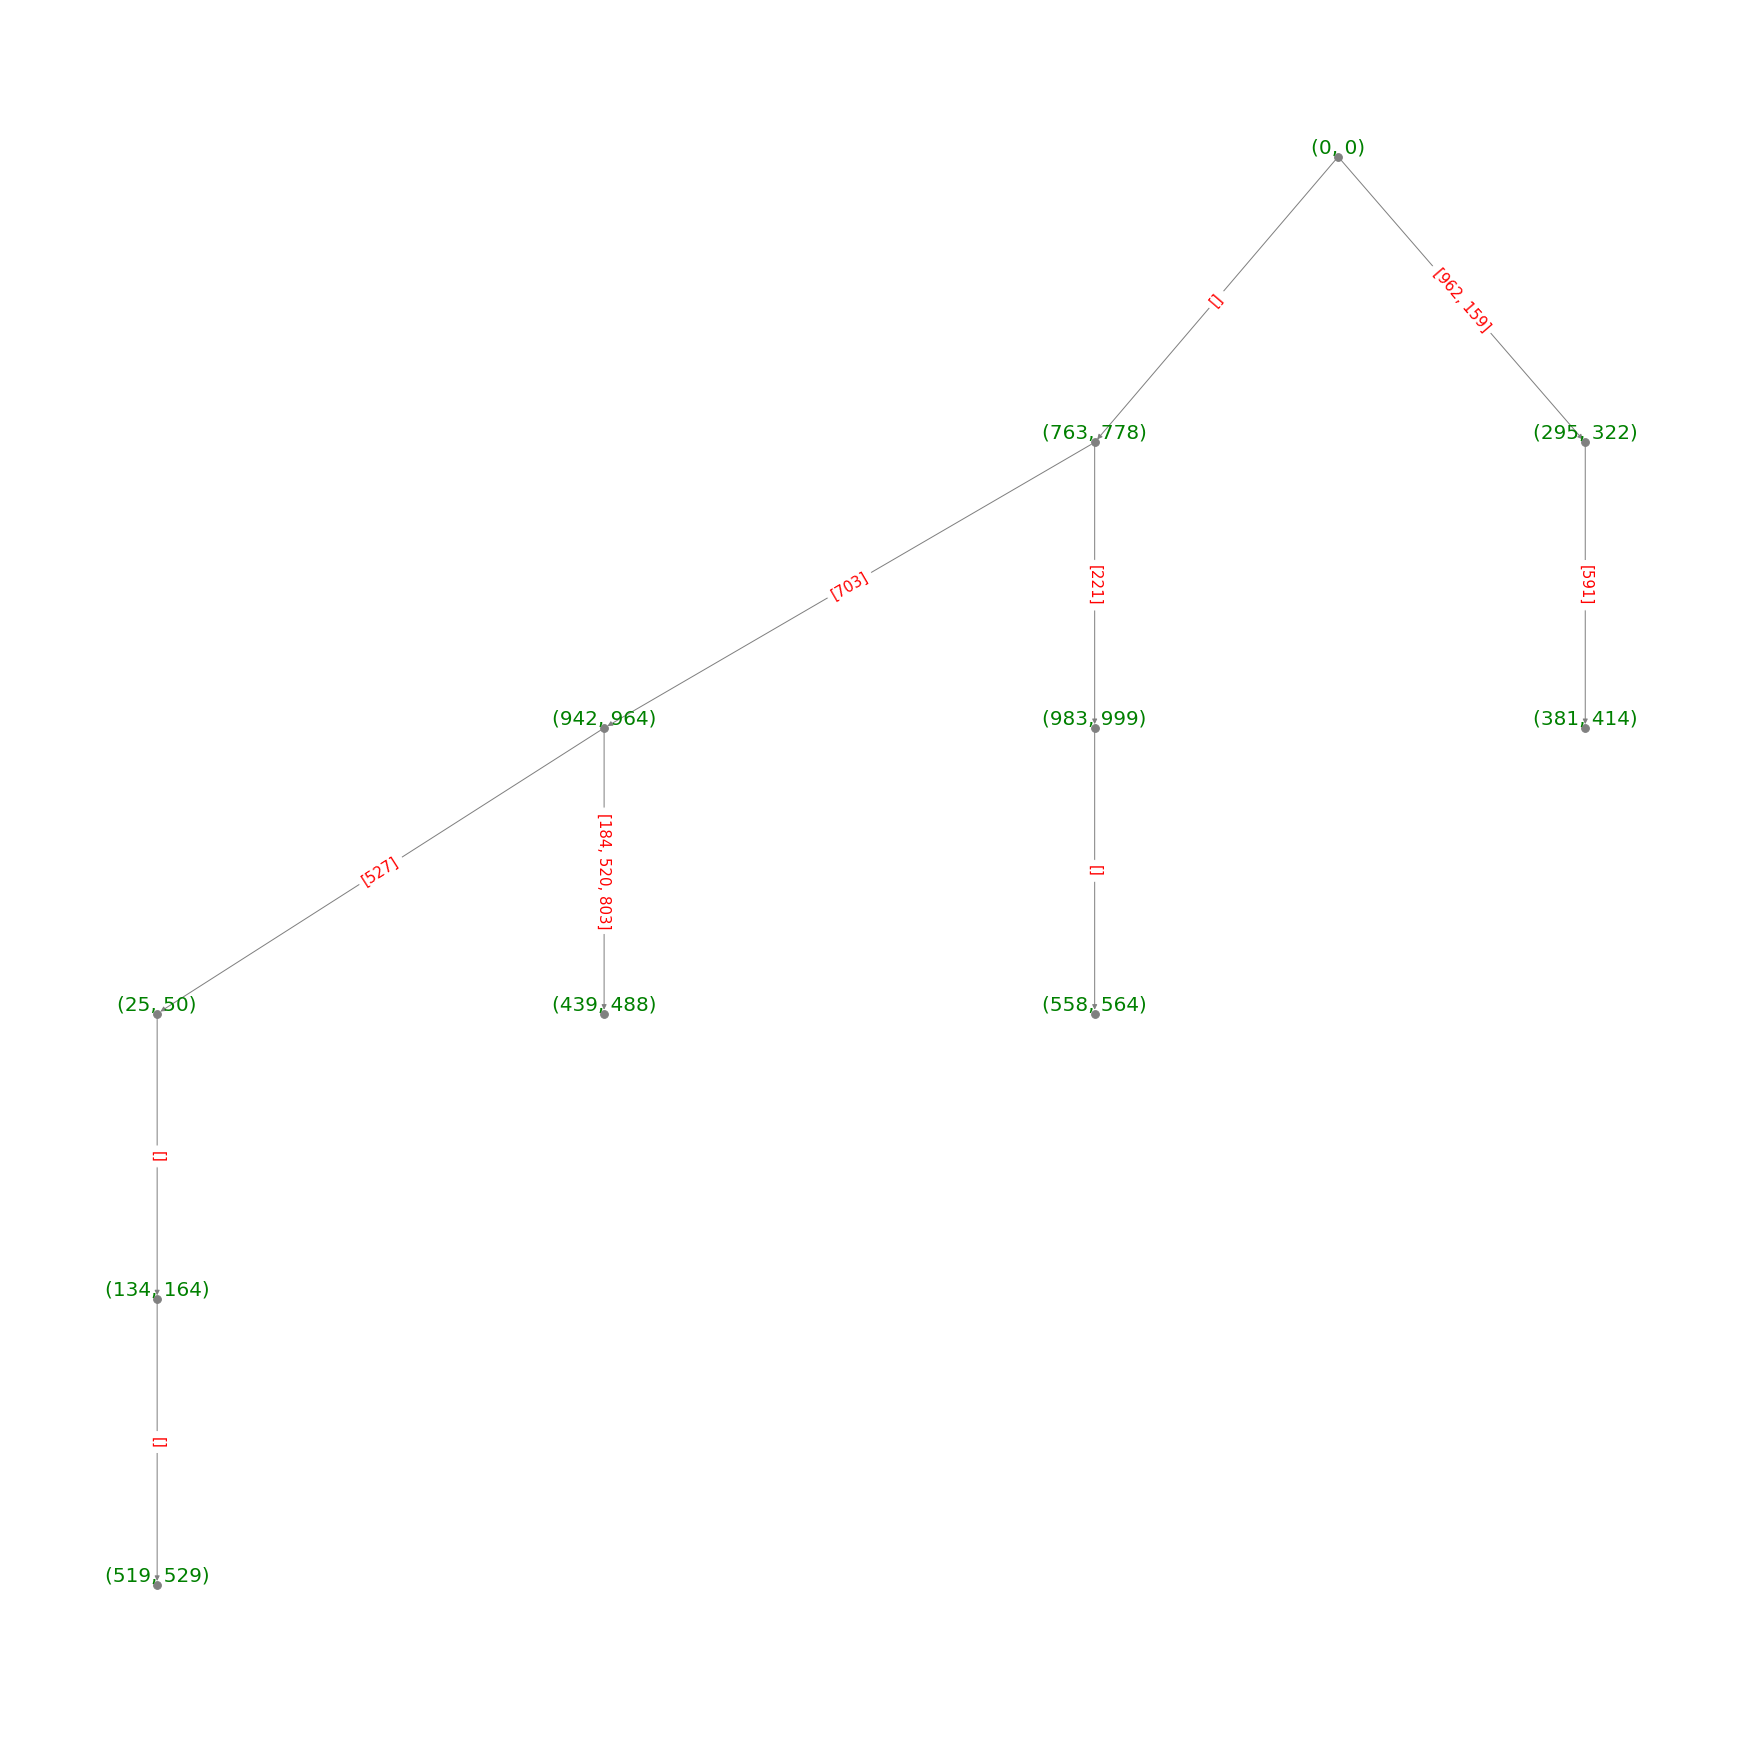

In [4]:
"""
DRAW TREE + SNVs 
"""

from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx 
import json
# Draw inferred tree 
plt.figure(3, figsize=(24, 24))
pos = graphviz_layout(model.event_tree.cn_event_tree, prog="dot")
nx.draw(model.event_tree.cn_event_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")


edge_dict = {} 
for edge in model.event_tree.cn_event_tree.edges: 
    edge_dict[edge] = json.dumps(list(model.event_tree.node_to_snvs[edge[1]]))
nx.draw_networkx_edge_labels(
    model.event_tree.cn_event_tree, pos,
    edge_labels=edge_dict,
    font_color='red', font_size = 15
)
plt.show()

In [5]:
CLUSTER_SIZE = 100
CLUSTERS = 20 

In [14]:
from solver import CellsData, MLSolver

In [7]:
cluster_to_cell_data = {}

for c in range(0, CLUSTERS):
    print(f"Generating cluster num {c}")
    node = next(model.generate_cell_attachment())
    cell = model.generate_cell_in_node(node)
    for _ in range(0, CLUSTER_SIZE - 1):
        cell2 = model.generate_cell_in_node(node)
        cell.d = cell.d + cell2.d 
        cell.b = cell.b + cell2.b
    cluster_to_cell_data[c] = cell 

Generating cluster num 0
Generating cluster num 1
Generating cluster num 2
Generating cluster num 3
Generating cluster num 4
Generating cluster num 5
Generating cluster num 6
Generating cluster num 7
Generating cluster num 8
Generating cluster num 9
Generating cluster num 10
Generating cluster num 11
Generating cluster num 12
Generating cluster num 13
Generating cluster num 14
Generating cluster num 15
Generating cluster num 16
Generating cluster num 17
Generating cluster num 18
Generating cluster num 19


In [8]:
cluster_to_size = dict([(c, CLUSTER_SIZE) for c in range(0, CLUSTERS)])
attachment = dict([(c, cluster_to_cell_data[c].attachment) for c in range(0, CLUSTERS)])

In [9]:
b = np.vstack([cluster_to_cell_data[c].b for c in range(0, CLUSTERS)])
d = np.vstack([cluster_to_cell_data[c].d for c in range(0, CLUSTERS)])

In [10]:
cells_data = CellsData(d=d, b=b, attachment=attachment, cell_cluster_sizes=cluster_to_size)

In [11]:
tree_with_snvs = model.event_tree
model.event_tree = model.event_tree.create_copy_without_snvs()

In [15]:
solver = MLSolver(cells_data, model, GeneratorContext())

In [17]:
solver.insert_snv_events()

KeyError: (0, 0)